**Анализ тональности при помощи BERT на примере imdb датасета**

Определим ф-ии предобработки и загрузки текста

In [1]:
import torch

In [2]:
from datasets import load_dataset
dataset = load_dataset("imdb")

Found cached dataset imdb (C:/Users/St0negor/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from torch.utils.data import Dataset, DataLoader
import string
def preprocess(doc):
    if type(doc) == str:
        doc = doc.lower()
        for p in string.punctuation + string.whitespace + 'http':
            doc = doc.replace(p, ' ')
        for p in ['«', '»', '\'', '\"']:
            doc = doc.replace(p, ' ')
        doc = doc.strip()
        doc = ' '.join([w for w in doc.split(' ') if w != ''])
    return doc

In [4]:
class IMDB(Dataset):
    def __init__(self, dataset, kind = 'train'):
        self.dataset = dataset
        self.kind = kind
    def __len__(self):
        return len(self.dataset[self.kind])
    def __getitem__(self, index):
        return (preprocess(dataset[self.kind]['text'][index]), dataset[self.kind]['label'][index])

In [5]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')
def collate_fn(batch):
    X = [e[0] for e in batch]
    y = [e[1] for e in batch]

    padded_sequences = tokenizer(X, add_special_tokens=True, padding='longest', truncation=True,max_length=256)

    tokens_tensor = torch.tensor(padded_sequences["input_ids"])
    attention_mask = torch.tensor(padded_sequences["attention_mask"])
    token_type_ids = torch.tensor(padded_sequences["token_type_ids"])

    labels_tensor = torch.tensor(y, dtype=torch.float)

    return (tokens_tensor, attention_mask, token_type_ids, labels_tensor)

Using cache found in C:\Users\St0negor/.cache\torch\hub\huggingface_pytorch-transformers_main


Определим BERT Модель с линейным слоем в конце

In [6]:
import transformers

In [7]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 1)

        for param in self.bert_model.parameters(): # Дообучаем модель поэтому градиенты для bert_model не рассчитываем
            param.requires_grad = False

    def forward(self, ids, mask, token_type_ids):
        _, output= self.bert_model(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.dropout(output)
        output = self.linear(output)
        return output

Функции тренировки и оценки модели

In [8]:
import numpy as np
from tqdm.autonotebook import tqdm

from transformers import logging
logging.set_verbosity_warning()


def train_model(model, criterion, optimizer, epochs, train_loader,device):
    for epoch in tqdm(range(epochs), total=epochs):
        for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):

            model.train()

            tokens, attention_mask, token_type_ids, labels = data

            tokens = tokens.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)

            y_pred = model(tokens, attention_mask, token_type_ids)
            loss = criterion(y_pred, labels.view(-1, 1))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i%5 == 0:
                model.eval()
                print(f'loss = {loss}')


    print(f'Done training after {epochs} epochs. Starting evaluation...')
    model.eval()

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
def eval_model(model, criterion, test_loader, device, n = 100):
    model.eval()
    losses = []
    accs = []
    cf_matrix = np.zeros((2,2))
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=n):
            tokens, attention_mask, token_type_ids, labels = data

            tokens = tokens.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)

            y_pred = model(tokens, attention_mask, token_type_ids)
            loss = criterion(y_pred, labels.view(-1, 1))
            acc = accuracy_score(np.round(torch.sigmoid(y_pred).cpu()), labels.cpu())
            cf_matrix += confusion_matrix(np.round(torch.sigmoid(y_pred).cpu()), labels.cpu())
            losses.append(loss.cpu())
            accs.append(acc)

            if(i>=n):
                break

        print(f'loss = {np.average(losses)}; accuracy = {np.average(accs)}')
        labels = ["True Neg","False Pos","False Neg","True Pos"]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='BuPu')

Построим базовую модель

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

loss = 0.7060690522193909
loss = 0.8057683706283569
loss = 0.7004907131195068
loss = 0.6865096092224121
loss = 0.7355697154998779
loss = 0.6963051557540894
loss = 0.7103497982025146
loss = 0.6596292853355408
loss = 0.6568715572357178
loss = 0.6602694392204285
loss = 0.6836937665939331
loss = 0.6743828058242798
loss = 0.6816708445549011
loss = 0.6969175338745117
loss = 0.6622278094291687
loss = 0.6499059200286865
loss = 0.6629077196121216
loss = 0.6389871835708618
loss = 0.6727259159088135
loss = 0.6621420383453369
Done training after 1 epochs. Starting evaluation...


  0%|          | 0/100 [00:00<?, ?it/s]

loss = 0.6363186240196228; accuracy = 0.6831683168316832
Wall time: 18min 34s


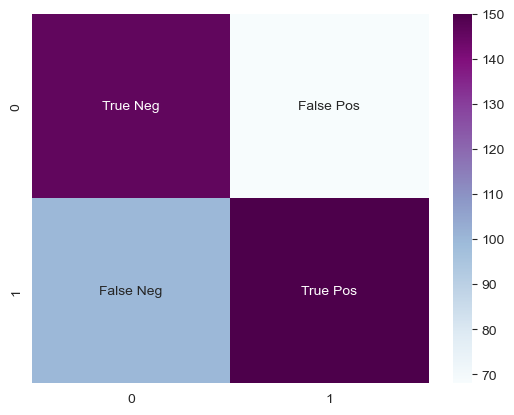

In [10]:
%%time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimus_prime = BERTClass()
optimus_prime.to(device)

learning_rate = 0.01
batch_size = 256
epochs = 1
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(optimus_prime.parameters(), lr=learning_rate)

train_set = IMDB(dataset,'train')
test_set = IMDB(dataset,'test')
train_loader = DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(dataset=test_set,batch_size=4,shuffle=True, collate_fn=collate_fn)

train_model(optimus_prime, criterion,optimizer, epochs, train_loader, device)
torch.cuda.empty_cache()
del train_loader
eval_model(optimus_prime, criterion, test_loader, device)
del optimus_prime
torch.cuda.empty_cache()

не хватило времени :(

Что бы я попробовал сделать для улучшения качества модели:

1) Увеличение кол-ва эпох
2) Регуляризация
3) Различные параметры lr_scheduler
4) Увеличить количество линейных слоев после BertModel